In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pymc as pm
import arviz as az
import os
import openpyxl

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'



In [3]:
final_df = pd.read_csv(interim_dir/'sims_notnull_200125.csv', index_col = [1,2])

In [4]:
final_df = (final_df
 .drop(['Unnamed: 0'], axis = 1)
 .assign(label = lambda df: df['Label'].apply(lambda x: 1 if x == 0 else 0))
 .drop(['Label'], axis = 1)
)

In [5]:
final_df['label'].value_counts()

label
0    187710
1      2943
Name: count, dtype: int64

In [19]:
final_df = (final_df.reset_index()
 .assign(pair = lambda df: df.apply(lambda row: tuple(sorted([row["Target"], row["Analogue"]])), axis=1)
        )
.drop_duplicates(subset=["pair"]).drop(columns=["pair"])
)
# Drop duplicate pairs
#df_unique = df.drop_duplicates(subset=["Pair"]).drop(columns=["Pair"])


In [16]:
similar_pairs = final_df[final_df['label'] == 1]
dissimilar_pairs = final_df[final_df['label'] ==0]

# Step 2: Downsample dissimilar pairs
downsampled_dissimilar_pairs = dissimilar_pairs.sample(n=len(similar_pairs), replace=False)

# Step 3: Combine balanced pairs
balanced_df = pd.concat([similar_pairs, downsampled_dissimilar_pairs])

# Step 4: Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [17]:
balanced_df[balanced_df['label'] ==1]

,,analogue_smi,target_smi,S_struct,S_react,S_physchem,S_metab,label
Target,Analogue,,,,,,,
DTXSID2059693,DTXSID7044764,CC(C)C(=O)OCCC1=CC=CC=C1,CC(C)CC(=O)OCCC1=CC=CC=C1,0.613636,1.0,0.937321,0.193775,1
DTXSID90286896,DTXSID3051545,CCOCCOC(=O)C=C,COCCOC(=O)CC(=C)C(=O)OCCOC,0.220000,1.0,0.734494,0.000000,1
DTXSID2063553,DTXSID10862696,CC=CC(C)O,CC=C(C)CO,0.190476,0.0,0.995166,0.000000,1
DTXSID50274032,DTXSID60860420,CC(C)CCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCC(C)C,CC(C)CCCCCCCOC(=O)C1=C(C=CC=C1)C(=O)OCCCCCCCC(C)C,0.975610,1.0,0.961196,0.200000,1
Pubchem_102283665,DTXSID9026342,OCCC1=CC=CC=C1,CCCCCCCCCC(=O)OCCCC1=CC=CC=C1,0.301887,1.0,0.533034,0.000000,1
...,...,...,...,...,...,...,...,...
DTXSID7032638,DTXSID9047542,COC=C(C(=O)OC)C1=CC=CC=C1COC1=CC=CC(=N1)C(F)(F)F,CON(C(=O)OC)C1=C(COC2=NN(C=C2)C2=CC=C(Cl)C=C2)...,0.209091,1.0,0.966728,0.088852,1
DTXSID1024621,DTXSID3025047,CCOCCOCCOCC,COCCOCCOC,0.350000,1.0,0.937090,0.000000,1
DTXSID5024182,DTXSID3051545,CCOCCOC(=O)C=C,COCCO,0.142857,0.0,0.772129,0.000000,1


In [24]:
from sklearn.model_selection import train_test_split

In [18]:
y = balanced_df['label'].values

In [19]:
balanced_df.columns

Index(['analogue_smi', 'target_smi', 'S_struct', 'S_react', 'S_physchem',
       'S_metab', 'label'],
      dtype='object')

In [20]:
X = balanced_df[[ 'S_struct', 'S_react', 'S_physchem',
       'S_metab']]

In [21]:
X1 = X.values

In [22]:
labels = X.columns.tolist()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, stratify = y, random_state=42)

In [26]:
coords = {"coeffs": labels}

with pm.Model(coords=coords) as model_all:
    # data containers
    
    X = pm.MutableData("X", X_train)
    y = pm.MutableData("y", y_train)
    # linear model
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    mu = pm.math.dot(X, b)
    # priors

    
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    pm.Bernoulli("Label", p=p, observed=y)

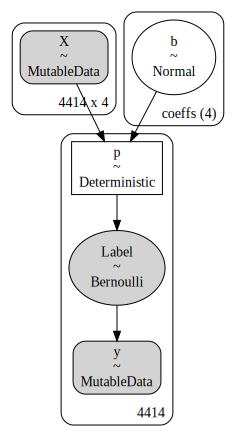

In [27]:
pm.model_to_graphviz(model_all)

In [28]:
with model_all:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


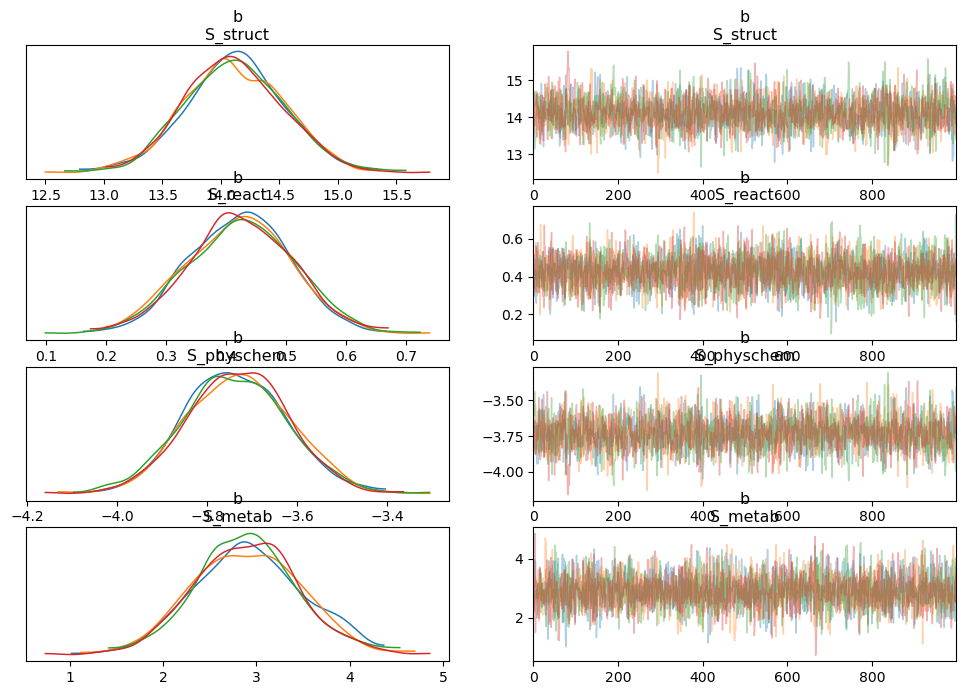

In [29]:
az.plot_trace(idata, var_names="b", compact=False);

In [30]:
az.summary(idata, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[S_struct],14.114,0.426,13.339,14.928,0.008,0.006,2645.0,2603.0,1.0
b[S_react],0.424,0.086,0.260,0.584,0.001,0.001,3589.0,2587.0,1.0
b[S_physchem],-3.734,0.115,-3.947,-3.519,0.002,0.002,2516.0,2103.0,1.0
b[S_metab],2.903,0.573,1.816,3.971,0.010,0.007,3521.0,2398.0,1.0


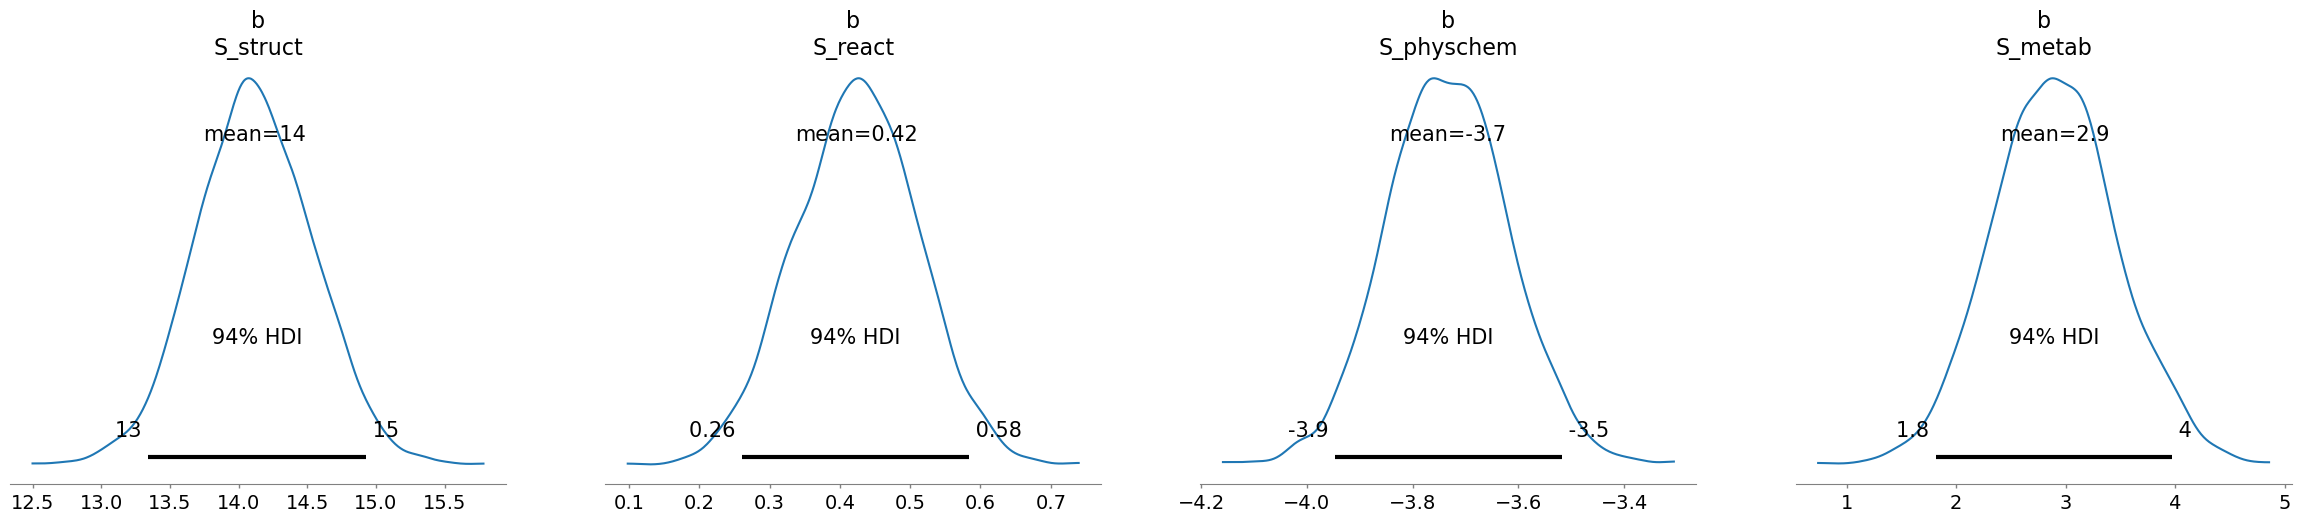

In [31]:
az.plot_posterior(
    idata, var_names=["b"],
)
plt.savefig(figures_dir/'posterior_plot.png', dpi = 300);


In [32]:
with model_all:
    pm.set_data({"X": X_test, "y": y_test})
    idata.extend(pm.sample_posterior_predictive(idata))


Sampling: [Label]


In [33]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive["Label"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()


In [34]:
print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")

accuracy =  0.872


In [35]:
from sklearn.metrics import balanced_accuracy_score

In [36]:
balanced_accuracy_score(y_test, y_test_pred)

0.8716032608695652

In [37]:
y_test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [38]:
from scipy.special import expit as inverse_logit
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

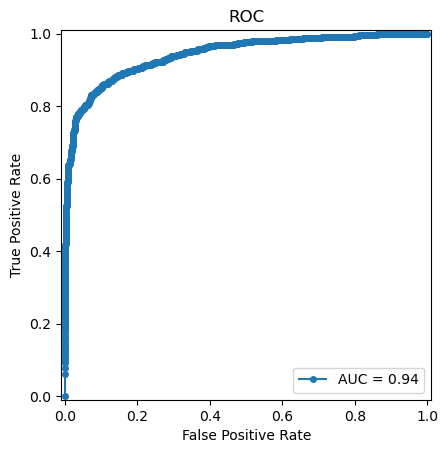

In [39]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");


In [40]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [41]:
def plot_confusion_matrix(cm, classes = ['dissimilar pair', 'analogue pair'],
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 9)
    plt.yticks(tick_marks, classes, rotation = 90, size = 9)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 9,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 9,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 9)
    plt.xlabel('Predicted Label', size = 9)
    


Confusion matrix
[[642  94]
 [ 95 641]]


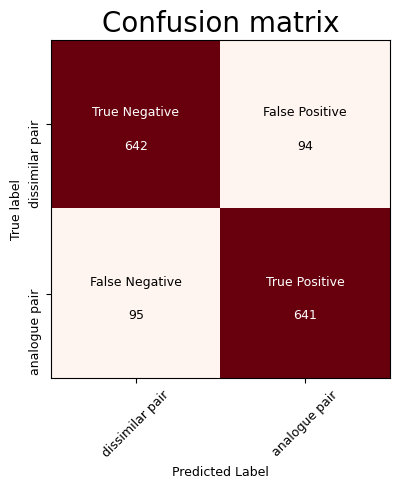

In [50]:
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm)
plt.savefig(figures_dir/'confusion matrix.png', dpi = 300)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split

In [44]:
lr = LogisticRegression()

In [45]:
cv = StratifiedKFold(n_splits = 10)
scorer = make_scorer(balanced_accuracy_score)

In [46]:
cv_scores = cross_validate(lr, X_train, y_train, cv = cv, scoring=scorer, n_jobs = -1)
cv_scores = pd.DataFrame(cv_scores)

In [47]:
lr.fit(X_train, y_train)
preds = lr.predict(X_test)


Confusion matrix
[[693  43]
 [ 55 681]]


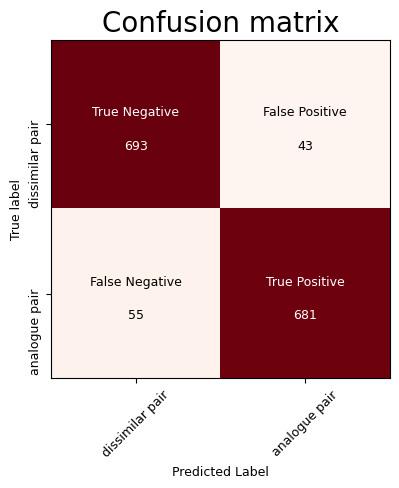

In [48]:
cm2 = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm2)

In [49]:
lr.coef_

array([[14.3608527 ,  1.1615973 ,  6.20694268,  3.05159076]])